In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
import stan
import nest_asyncio
from mpl_toolkits.mplot3d import Axes3D
nest_asyncio.apply()
import time
import arviz as az
import itertools

In [2]:
# Distribution parameters
alpha_b = 6  # Beta distribution for 'b'
beta_param_b = 1.7
mu_c = 0.4  # Normal distribution for 'c'
sigma_c = 0.1
mu_j = 0.18  # Normal distribution for 'j'
sigma_j = 0.03


np.random.seed(4)

# Function to sample a score based on the individual component
def sample_score(component):
    if component == 'j':
        return np.random.normal(mu_j, sigma_j)
    elif component == 'c':
        return np.random.normal(mu_c, sigma_c)
    elif component == 'b':
        return np.random.beta(alpha_b, beta_param_b)
    else:
        raise ValueError(f"Unknown component: {component}")  #just in case

# Generate unique permutations
def unique_permutations(elements):
    return list(set(itertools.permutations(elements)))

# Generate the unique permutations
bbjj_permutations = unique_permutations(['b', 'b', 'j', 'j'])
ccbb_permutations = unique_permutations(['c', 'c', 'b', 'b'])
jjcc_permutations = unique_permutations(['j', 'j', 'c', 'c'])

#print(bbjj_permutations)

def generate_scores_with_labels(class_label):
    if class_label == 'jjjj':
        scores = [sample_score('j') for _ in range(4)]
        labels = ['j', 'j', 'j', 'j']
    elif class_label == 'bbbb':
        scores = [sample_score('b') for _ in range(4)]
        labels = ['b', 'b', 'b', 'b']
    elif class_label == 'cccc':
        scores = [sample_score('c') for _ in range(4)]
        labels = ['c', 'c', 'c', 'c']
    elif class_label == 'bbjj':
        perm = np.random.choice(len(bbjj_permutations))  # Select a unique permutation
        labels = bbjj_permutations[perm]
        scores = [sample_score(comp) for comp in labels]
    elif class_label == 'ccbb':
        perm = np.random.choice(len(ccbb_permutations))  # Select a unique permutation
        labels = ccbb_permutations[perm]
        scores = [sample_score(comp) for comp in labels]
    elif class_label in ['jjcc', 'ccjj']:  # Both use the same permutations
        perm = np.random.choice(len(jjcc_permutations))  # Select a unique permutation
        labels = jjcc_permutations[perm]
        scores = [sample_score(comp) for comp in labels]
    else:
        raise ValueError(f"Unknown class: {class_label}")  # just in case
    
    return scores, labels

# Generate classes based on the probabilities and sample the scores
N = 1000
classes = ["jjjj", "bbjj", "ccjj", "cccc", "ccbb", "bbbb"]
p = [0.2, 0.2, 0.18, 0.17, 0.15, 0.1]  # probabilities for each class
class_column = np.random.choice(classes, size=N, p=p)

data = []
for c in class_column:
    try:
        scores, labels = generate_scores_with_labels(c)
        data.append(scores + [c] + list(labels))  # Add scores, class, and labels
    except ValueError as e:
        print(e)  # just in case

# Create the DataFrame with the new label columns
df = pd.DataFrame(data, columns=['s1', 's2', 's3', 's4', 'class', 'label_s1', 'label_s2', 'label_s3', 'label_s4'])


df

,s1,s2,s3,s4,class,label_s1,label_s2,label_s3,label_s4
0,0.674077,0.883516,0.655083,0.799011,bbbb,b,b,b,b
1,0.520235,0.158099,0.491599,0.158290,ccjj,c,j,c,j
2,0.929835,0.867007,0.695784,0.881500,bbbb,b,b,b,b
3,0.312131,0.486232,0.541720,0.492862,cccc,c,c,c,c
4,0.130836,0.370183,0.387333,0.216802,cccc,c,c,c,c
...,...,...,...,...,...,...,...,...,...
995,0.552540,0.156200,0.452597,0.193912,ccjj,c,j,c,j
996,0.363478,0.347120,0.194509,0.134027,ccjj,c,c,j,j
997,0.265133,0.860522,0.346954,0.835525,ccbb,c,b,c,b
998,0.725789,0.900351,0.171500,0.157591,bbjj,b,b,j,j


In [3]:
df['label_s1'].value_counts()

label_s1
j    391
c    334
b    275
Name: count, dtype: int64

In [4]:
# Obtener el conteo de cada clase
class_counts = df['class'].value_counts()
print(class_counts)
# Calcular las fracciones dividiendo por el total N
class_fractions = class_counts / N

# Convertir a lista
class_fractions_list = class_fractions.tolist()

class_fractions_list_rounded = [round(fraction, 2) for fraction in class_fractions_list]
print('')
print(class_fractions_list_rounded,'data fraction')
print(p,'true fraction')

class
jjjj    207
cccc    182
ccjj    179
bbjj    177
ccbb    149
bbbb    106
Name: count, dtype: int64

[0.21, 0.18, 0.18, 0.18, 0.15, 0.11] data fraction
[0.2, 0.2, 0.18, 0.17, 0.15, 0.1] true fraction


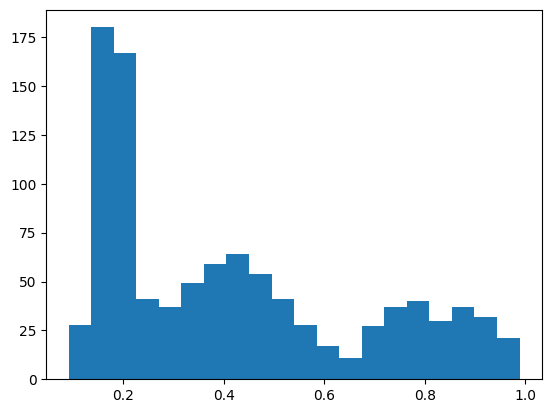

In [5]:
plt.hist(df['s1'],bins=20,density=False)
plt.show()

In [6]:
m = 20

# Function to rescale values to the interval [1, m] and convert to integers
def rescale_to_interval(values, m):
    return np.round(values * (m - 1) + 1).astype(int)

# Create a copy of the original DataFrame
df_rescaled = df.copy()

# Apply rescaling to each score column in the new DataFrame
df_rescaled['s1'] = rescale_to_interval(df_rescaled['s1'], m)
df_rescaled['s2'] = rescale_to_interval(df_rescaled['s2'], m)
df_rescaled['s3'] = rescale_to_interval(df_rescaled['s3'], m)
df_rescaled['s4'] = rescale_to_interval(df_rescaled['s4'], m)

# Display the rescaled DataFrame
print(df_rescaled.head())

# Show the value counts for the class column in the rescaled DataFrame
print(df_rescaled['class'].value_counts())

# Check the total number of rows in the rescaled DataFrame
print(len(df_rescaled))


   s1  s2  s3  s4 class label_s1 label_s2 label_s3 label_s4
0  14  18  13  16  bbbb        b        b        b        b
1  11   4  10   4  ccjj        c        j        c        j
2  19  17  14  18  bbbb        b        b        b        b
3   7  10  11  10  cccc        c        c        c        c
4   3   8   8   5  cccc        c        c        c        c
class
jjjj    207
cccc    182
ccjj    179
bbjj    177
ccbb    149
bbbb    106
Name: count, dtype: int64
1000


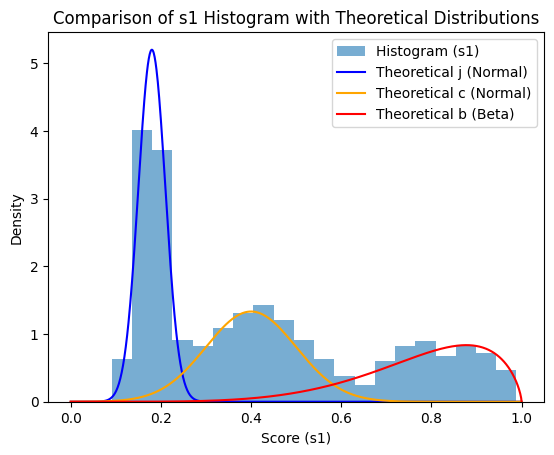

In [7]:
# Values for the x-axis
x = np.linspace(0, 1, 1000)  # Range of possible values for s1

# Theoretical distributions
pdf_j = norm.pdf(x, mu_j, sigma_j)  # Normal distribution for 'j'
pdf_c = norm.pdf(x, mu_c, sigma_c)  # Normal distribution for 'c'
pdf_b = beta.pdf(x, alpha_b, beta_param_b)  # Beta distribution for 'b'

# Plot the histogram of s1
plt.hist(df['s1'], bins=20, density=True, alpha=0.6, label='Histogram (s1)')

# Plot the theoretical distributions
plt.plot(x, pdf_j*df['label_s1'].value_counts()['j']/N, label='Theoretical j (Normal)', color='blue')
plt.plot(x, pdf_c*df['label_s1'].value_counts()['c']/N, label='Theoretical c (Normal)', color='orange')
plt.plot(x, pdf_b*df['label_s1'].value_counts()['b']/N, label='Theoretical b (Beta)', color='red')

# Add labels and legend
plt.xlabel('Score (s1)')
plt.ylabel('Density')
plt.legend()
plt.title('Comparison of s1 Histogram with Theoretical Distributions')

# Show the plot
plt.show()

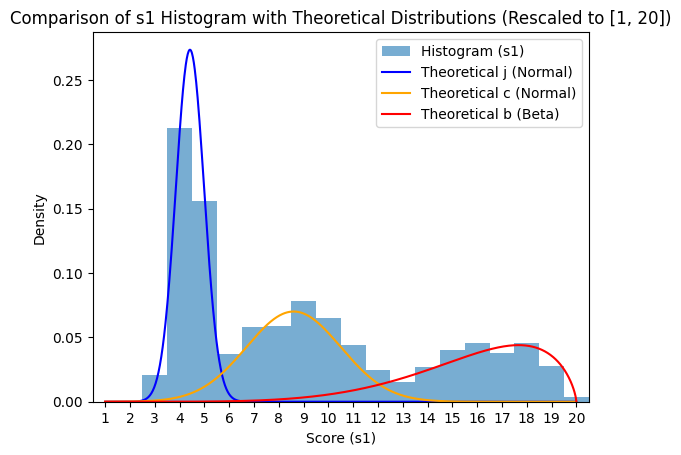

In [30]:
# Valores del eje x reescalados a [1, m]
x_rescaled = np.linspace(1, m, 1000)  # Rango de valores posibles para s1

# Ajustar las distribuciones teóricas a [1, m]
pdf_j_rescaled = norm.pdf((x_rescaled - 1) / (m - 1), mu_j, sigma_j) / (m - 1)  # Normal para 'j' reescalada
pdf_c_rescaled = norm.pdf((x_rescaled - 1) / (m - 1), mu_c, sigma_c) / (m - 1)  # Normal para 'c' reescalada
pdf_b_rescaled = beta.pdf((x_rescaled - 1) / (m - 1), alpha_b, beta_param_b) / (m - 1)  # Beta para 'b' reescalada

bin_edges = np.arange(0.5, m + 1.5, 1)
# Graficar el histograma de s1 reescalado
plt.hist(df_rescaled['s1'], bins=bin_edges, density=True, alpha=0.6, label='Histogram (s1)')

# Graficar las distribuciones teóricas reescaladas
plt.plot(x_rescaled, pdf_j_rescaled * df['label_s1'].value_counts()['j'] / N, label='Theoretical j (Normal)', color='blue')
plt.plot(x_rescaled, pdf_c_rescaled * df['label_s1'].value_counts()['c'] / N, label='Theoretical c (Normal)', color='orange')
plt.plot(x_rescaled, pdf_b_rescaled * df['label_s1'].value_counts()['b'] / N, label='Theoretical b (Beta)', color='red')

# Añadir etiquetas y leyenda
plt.xlabel('Score (s1)')
plt.ylabel('Density')
plt.legend()
plt.xlim(0.5,m+0.5)
plt.title(f'Comparison of s1 Histogram with Theoretical Distributions (Rescaled to [1, {m}])')
plt.xticks(range(1,m+1))
# Mostrar el gráfico
plt.show()


20.55836840278443

In [9]:
score = df_rescaled[['s1', 's2', 's3', 's4']].values.tolist()
print(score[:3])
print(len(score))

[[14, 18, 13, 16], [11, 4, 10, 4], [19, 17, 14, 18]]
1000


In [101]:
my_mixture_4d = """
functions {
  real partial_sum(array[,] int score_slice,
                   int start, int end,
                   vector yj,
                   vector yb,
                   vector yc,
                   vector theta)
  {
    real permutation_factor = 1.0/6;
    real partial_target = 0;
    
    vector[6] lp;   // Six distinct classes: jjjj, bbjj (+perm), bbbb, bbcc (+perm), jjcc (+perm), and cccc.
    vector[6] lp2;  // To handle permutations for bbjj
    vector[6] lp3;  // To handle permutations for bbcc
    vector[6] lp4;  // To handle permutations for jjcc.
    
    int slice_length = end - start + 1;

    for (k in 1:slice_length) {
      // Permutations for bbjj
      lp2[1] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
      lp2[2] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
      lp2[3] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yj)[score_slice[k,4]];
      lp2[4] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
      lp2[5] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yj)[score_slice[k,4]];
      lp2[6] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yj)[score_slice[k,4]];

      // Assign probabilities for the six classes
      lp[1] = log(yj)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yj)[score_slice[k,4]]; // jjjj
      lp[2] = log_sum_exp(lp2);    // bbjj + permutations
      lp[3] = log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]]; // bbbb

      // Permutations for bbcc
      lp3[1] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
      lp3[2] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
      lp3[3] = log(permutation_factor) + log(yb)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
      lp3[4] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
      lp3[5] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yb)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
      lp3[6] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yb)[score_slice[k,3]] + log(yb)[score_slice[k,4]];
      lp[4] = log_sum_exp(lp3);    // bbcc + permutations

      // Permutations for jjcc
      lp4[1] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
      lp4[2] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
      lp4[3] = log(permutation_factor) + log(yj)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yj)[score_slice[k,4]];
      lp4[4] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yc)[score_slice[k,4]];
      lp4[5] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yj)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yj)[score_slice[k,4]];
      lp4[6] = log(permutation_factor) + log(yc)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yj)[score_slice[k,3]] + log(yj)[score_slice[k,4]];
      lp[5] = log_sum_exp(lp4);    // jjcc + permutations

      lp[6] = log(yc)[score_slice[k,1]] + log(yc)[score_slice[k,2]] + log(yc)[score_slice[k,3]] + log(yc)[score_slice[k,4]]; // cccc

      partial_target += log_mix(theta, lp);
    }

    return partial_target;
  }
}

data {
  int<lower=1> m;  // steps in the discretization
  int<lower=1> N;  // data points
  array[N,4] int<lower=1, upper=m> score;  // b-tagging score for jet#1
}

parameters {
  simplex[6] theta;  // Mixture coefficients of 6 classes as a simplex
  
  simplex[m] w_j_mode;  // Dirichlet weights for the background (jjjj and permutations)
  vector<lower=0>[m-1] a_j;  // Normal parameters for background
  
  simplex[m] w_b_mode;  // Dirichlet weights for the signal (bbbb and permutations)
  vector<lower=0>[m-1] a_b;  // Normal parameters for signal
  
  simplex[m] w_c_mode;  // Dirichlet weights for component c (cccc and permutations)
  vector<lower=0>[m-1] a_c;  // Normal parameters for component c
}

transformed parameters {
  ordered[2] y_label_switch_1;
  ordered[2] y_label_switch_2;
  ordered[2] y_label_switch_3;
  ordered[2] y_label_switch_4;
  ordered[2] y_label_switch_5;
  ordered[2] y_label_switch_6;
  ordered[2] y_label_switch_7;

  vector[m] p_j;  // Approximate distribution for j
  vector[m-1] sign_j;  // Signs for combination
  vector[m] logp_j;  // Log-probabilities
  
  sign_j = rep_vector(-1.0, m-1);
  p_j = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_j[j] = 1.0;
      }
    }
    logp_j[1] = 0.0;
    for (j in 2:m) {
      logp_j[j] = logp_j[j-1] + sign_j[j-1] * a_j[j-1];
    }
    p_j += softmax(logp_j) * w_j_mode[k];
  }

  vector[m] p_b;  // Approximate distribution for b
  vector[m-1] sign_b;  // Signs for combination
  vector[m] logp_b;  // Log-probabilities

  sign_b = rep_vector(-1.0, m-1);
  p_b = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_b[j] = 1.0;
      }
    }
    logp_b[1] = 0.0;
    for (j in 2:m) {
      logp_b[j] = logp_b[j-1] + sign_b[j-1] * a_b[j-1];
    }
    p_b += softmax(logp_b) * w_b_mode[k];
  }
  
  vector[m] p_c;  // Approximate distribution for c
  vector[m-1] sign_c;  // Signs for combination
  vector[m] logp_c;  // Log-probabilities
  
  sign_c = rep_vector(-1.0, m-1);
  p_c = rep_vector(0.0, m);

  for (k in 1:m) {
    if (k > 1) {
      for (j in 1:(k-1)) {
        sign_c[j] = 1.0;
      }
    }
    logp_c[1] = 0.0;
    for (j in 2:m) {
      logp_c[j] = logp_c[j-1] + sign_c[j-1] * a_c[j-1];
    }
    p_c += softmax(logp_c) * w_c_mode[k];
  }

  y_label_switch_1[1] = p_c[5];
  y_label_switch_1[2] = p_j[5];
  
  y_label_switch_2[1] = p_c[4];
  y_label_switch_2[2] = p_j[4];
  
  y_label_switch_3[1] = p_b[5];
  y_label_switch_3[2] = p_j[5];

  y_label_switch_4[1] = p_b[8];
  y_label_switch_4[2] = p_c[8];

  y_label_switch_5[1] = p_j[8];
  y_label_switch_5[2] = p_c[8];
  
  y_label_switch_6[1] = p_c[16];
  y_label_switch_6[2] = p_b[16];

  y_label_switch_7[1] = p_j[16];
  y_label_switch_7[2] = p_b[16];
  



}

model {
  int grainsize = 1;  // Adjust for parallel performance

  // Priors
  theta ~ dirichlet(rep_vector(1.0, 6));

  a_j ~ normal(0, 0.5);
  a_b ~ normal(0, 0.5);
  a_c ~ normal(0, 0.5);

  w_j_mode ~ dirichlet(rep_vector(1.0, m));
  w_b_mode ~ dirichlet(rep_vector(1.0, m));
  w_c_mode ~ dirichlet(rep_vector(1.0, m));

  target += reduce_sum(partial_sum, score, grainsize, p_j, p_b, p_c, theta);
}

"""

In [102]:
# Start the timer
start_time_4d = time.time()

# Build and sample from the 2D mixture model
model_4d = stan.build(my_mixture_4d, data={'m': m, 'N': len(score), 'score':score},random_seed=33)
fit_4d = model_4d.sample(num_chains=4, num_samples=1000, num_warmup = 1000)
df_4d = fit_4d.to_frame()

# Stop the timer
end_time_4d = time.time()

# Calculate the elapsed time
elapsed_time_4d = end_time_4d - start_time_4d

# Print the elapsed time
print(f"Time taken to run the 2D model: {elapsed_time_4d:.2f} seconds")


Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 

Building: 26.0s
Building: 26.1s
Building: 26.2s
Building: 26.3s
Building: 26.4s
Building: 26.5s
Building: 26.6s
Building: 26.8s
Building: 26.9s
Building: 27.0s
Building: 27.1s
Building: 27.2s
Building: 27.3s
Building: 27.4s
Building: 27.5s
Building: 27.6s
Building: 27.7s
Building: 27.8s
Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.2s
Building: 28.3s
Building: 28.4s
Building: 28.5s
Building: 28.6s
Building: 28.7s
Building: 28.8s
Building: 28.9s
Building: 29.0s
Building: 29.1s
Building: 29.2s
Building: 29.3s
Building: 29.4s
Building: 29.5s
Building: 29.6s
Building: 29.7s
Building: 29.8s
Building: 29.9s
Building: 30.0s
Building: 30.1s
Building: 30.2s
Building: 30.3s
Building: 30.4s
Building: 30.5s
Building: 30.6s
Building: 30.7s
Building: 30.8s
Building: 30.9s
Building: 31.0s
Building: 31.1s
Building: 31.2s
Building: 31.3s
Building: 31.4s
Building: 31.5s
Building: 31.6s
Building: 31.7s
Building: 31.9s
Building: 32.0s
Building: 32.1s
Building: 32.2s
Building: 32.3s
Building

Building: 34.4s, done.
Messages from stanc:
Warning in '/tmp/httpstan_vzexu2br/model_rwfoqxx5.stan', line 184, column 12: The
    variable partial_sum may not have been assigned a value before its use.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (203/8000)
Sampling:   4% (303/8000)
Sampling:   5% (403/8000)
Sampling:   6% (503/8000)
Sampling:   8% (602/8000)
Sampling:   9% (702/8000)
Sampling:  10% (802/8000)
Sampling:  11% (902/8000)
Sampling:  13% (1001/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1301/8000)
Sampling:  18% (1401/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/

warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0506461, but should be greater than the previous element, 0.0702293 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0642524, but should be greater than the previous element, 0.134901 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_5 is not a valid ordered vector. The element at 2 is 0.0420796, but should be greater than the previous element, 0.0656332 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 85, column 2 to colu

warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.031243, but should be greater than the previous element, 0.0895882 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0710796, but should be greater than the previous element, 0.0824488 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0881202, but should be greater than the previou

warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0302152, but should be greater than the previous element, 0.0776833 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_6 is not a valid ordered vector. The element at 2 is 0.0744279, but should be greater than the previous element, 0.0751619 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 86, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.00987431, but should be greater than the previ

warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0114716, but should be greater than the previous element, 0.125844 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0561699, but should be greater than the previous element, 0.122063 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_6 is not a valid ordered vector. The element at 2 is 0.0188369, but should be greater than the previous

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0479093, but should be greater than the previous element, 0.0479796 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: mode

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0760969, but should be greater than the previous element, 0.0768291 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0804715, but should be greater than

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0709992, but should be greater than the previous element, 0.0710842 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.071108, but should be greater than the previous element, 0.071111 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to colum

warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0320292, but should be greater than the previous element, 0.0495712 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0474631, but should be greater than the previous element, 0.0566771 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.090826, but should be greater than the previou

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.131864, but should be greater than the previous element, 0.260578 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.125166, but should be greater than the previous element, 0.200129 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.15476, but should be greater than the previous element, 0.154804 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.154612, but should be greater than the previous element, 0.15471 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.154776, but should be greater than the previous element, 0.154782 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.154492, but should be greater than the previous element, 0.154512 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.154159, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.154704, but should be greater than the previous element, 0.154723 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.154996, but should be greater than the previous element, 0.155016 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.155339, but should be greater than the previous element, 0.155615 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.155597, but should be greater than the previous element, 0.156028 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.158081, but should be greater than the previous element, 0.160025 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.157819, but should be greater than the previous element, 0.158287 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0598787, but should be greater than t

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.15706, but should be greater than the previous element, 0.157461 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.156986, but should be greater than the previous element, 0.157114 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 3

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.156998, but should be greater than the previous element, 0.157013 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.157446, but should be greater than the previous element, 0.15746 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.152731, but should be greater than the previous element, 0.152862 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.152591, but should be greater than the previous element, 0.152624 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.152792, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.15203, but should be greater than the previous element, 0.1521 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.151852, but should be greater than the previous element, 0.151921 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150991, but should be greater than the previous element, 0.150996 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.151198, but should be greater than the previous element, 0.151285 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150804, but should be greater than the previous element, 0.150807 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150686, but should be greater than the previous element, 0.150862 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.149544, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150485, but should be greater than the previous element, 0.150514 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150338, but should be greater than the previous element, 0.150372 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150652, but should be greater than the previous element, 0.15066 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150636, but should be greater than the previous element, 0.150646 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150532, but should be greater than the previous element, 0.150534 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150315, but should be greater than the previous element, 0.150418 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150008, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150321, but should be greater than the previous element, 0.150331 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150279, but should be greater than the previous element, 0.150279 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150254, but should be greater than the previous element, 0.150263 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150289, but should be greater than the previous element, 0.15029 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.150393, but should be greater than the previous element, 0.150395 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.148349, but should be greater than the previous element, 0.148834 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147821, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147825, but should be greater than the previous element, 0.147825 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147821, but should be greater than the previous element, 0.147821 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147826, but should be greater than the previous element, 0.147826 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147829, but should be greater than the previous element, 0.14783 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147822, but should be greater than the previous element, 0.147824 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.14741, but should be greater than the previous element, 0.147434 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.14748, but should be greater than the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147327, but should be greater than the previous element, 0.147367 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.147688, but should be greater than the previous element, 0.147728 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.14554, but should be greater than the previous element, 0.145772 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.14605, but should be greater than the previous element, 0.146106 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, 

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.14555, but should be greater than the previous element, 0.14567 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rw

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.14591, but should be greater than the previous element, 0.146063 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.145661, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.145333, but should be greater than the previous element, 0.145341 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.145677, but should be greater than the previous element, 0.145762 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.144733, but should be greater than the previous element, 0.144771 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.144816, but should be greater than the previous element, 0.144886 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.144771, but should be greater than the previous element, 0.144801 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.144876, but should be greater than the previous element, 0.144923 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.144736, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.144866, but should be greater than the previous element, 0.144866 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.144857, but should be greater than the previous element, 0.144858 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.14318, but should be greater than the previous element, 0.143426 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.143091, but should be greater than the previous element, 0.143357 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.142325, but should be greater than the previous element, 0.142459 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.142548, but should be greater than the previous element, 0.14286 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.142759, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.142719, but should be greater than the previous element, 0.142731 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.142843, but should be greater than the previous element, 0.142849 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.141912, but should be greater than the previous element, 0.141941 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.141917, but should be greater than the previous element, 0.142069 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.139609, but should be greater than the previous element, 0.139745 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.139783, but should be greater than the previous element, 0.1398 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.139639, but should be greater than the 

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.140011, but should be greater than the previous element, 0.140017 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.139532, but should be greater than the previous element, 0.139556 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.139238, but should be greater than the previous element, 0.139262 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.139146, but should be greater than the previous element, 0.139168 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.139313, but should be greater than the previous element, 0.139317 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.123009, but should be greater than the previous element, 0.12306 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122915, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.123155, but should be greater than the previous element, 0.123229 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.12294, but should be greater than the previous element, 0.122953 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 3

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122259, but should be greater than the previous element, 0.122273 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.121992, but should be greater than the previous element, 0.122037 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122192, but should be greater than the previous element, 0.122202 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.12196, but should be greater than the previous element, 0.122052 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122151, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122329, but should be greater than the previous element, 0.122387 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122208, but should be greater than the previous element, 0.122209 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122167, but should be greater than the previous element, 0.12218 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122134, but should be greater than the previous element, 0.122222 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.122058, but should be greater than the previous element, 0.122112 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.121785, but should be greater than the previous element, 0.121847 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.121766, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.121271, but should be greater than the previous element, 0.12131 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.121246, but should be greater than the previous element, 0.121292 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 3

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.121146, but should be greater than the previous element, 0.121172 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.120921, but should be greater than the previous element, 0.120985 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.121318, but should be greater than the previous element, 0.121323 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.120832, but should be greater than the previous element, 0.120892 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.12053, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.120032, but should be greater than the previous element, 0.120034 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119652, but should be greater than the previous element, 0.119671 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119496, but should be greater than the previous element, 0.119543 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119588, but should be greater than the previous element, 0.119678 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119681, but should be greater than the previous element, 0.119753 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119496, but should be greater than the previous element, 0.119548 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119548, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119789, but should be greater than the previous element, 0.11981 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119581, but should be greater than the previous element, 0.119635 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 3

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.120094, but should be greater than the previous element, 0.120177 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119979, but should be greater than the previous element, 0.119997 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119763, but should be greater than the previous element, 0.119768 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119467, but should be greater than the previous element, 0.119509 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119401, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119436, but should be greater than the previous element, 0.119454 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119179, but should be greater than the previous element, 0.119258 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119355, but should be greater than the previous element, 0.119428 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119366, but should be greater than the previous element, 0.11942 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119008, but should be greater than the previous element, 0.119011 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118764, but should be greater than the previous element, 0.118808 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.11894, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.11878, but should be greater than the previous element, 0.118823 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118641, but should be greater than the previous element, 0.118671 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 3

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119099, but should be greater than the previous element, 0.119112 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118986, but should be greater than the previous element, 0.118994 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119216, but should be greater than the previous element, 0.11927 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_r

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.119396, but should be greater than the previous element, 0.119421 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118998, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118637, but should be greater than the previous element, 0.118671 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118706, but should be greater than the previous element, 0.118793 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118517, but should be greater than the previous element, 0.118525 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118509, but should be greater than the previous element, 0.118549 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118827, but should be greater than the previous element, 0.118847 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118124, but should be greater than the previous element, 0.118201 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.11824, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118192, but should be greater than the previous element, 0.118212 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118191, but should be greater than the previous element, 0.118236 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118368, but should be greater than the previous element, 0.118456 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118483, but should be greater than the previous element, 0.118491 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117951, but should be greater than the previous element, 0.118079 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117974, but should be greater than the previous element, 0.118015 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.118074, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117738, but should be greater than the previous element, 0.117842 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117738, but should be greater than the previous element, 0.117795 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116698, but should be greater than the previous element, 0.116755 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116857, but should be greater than the previous element, 0.116938 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116721, but should be greater than the previous element, 0.116769 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116952, but should be greater than the previous element, 0.116985 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.11693, but should be greater than the

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117196, but should be greater than the previous element, 0.117225 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.11719, but should be greater than the previous element, 0.117253 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 3

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117134, but should be greater than the previous element, 0.117207 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117336, but should be greater than the previous element, 0.117365 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117052, but should be greater than the previous element, 0.117061 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116757, but should be greater than the previous element, 0.116765 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116703, but should be greater than th

  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116806, but should be greater than the previous element, 0.116887 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117076, but should be greater than the previous element, 0.117128 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 

  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116973, but should be greater than the previous element, 0.11699 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.117281, but should be greater than the previous element, 0.117336 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.116048, but should be greater than the previous element, 0.116091 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_

warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0532989, but should be greater than the previous element, 0.183809 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0500437, but should be greater than the previous element, 0.0917953 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0732605, but should be greater than the previous element, 0.0744899 (in '/tmp

warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_4 is not a valid ordered vector. The element at 2 is 0.0221379, but should be greater than the previous element, 0.02631 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 84, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_6 is not a valid ordered vector. The element at 2 is 0.00394241, but should be greater than the previous element, 0.0255049 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 86, column 2 to column 30)
warn:Rejecting initial value:
warn:  Error evaluating the log probability at the initial value.
warn:Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0655542, but should be greater than the previou

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: model_rwfoqxx5_namespace::log_prob: y_label_switch_1 is not a valid ordered vector. The element at 2 is 0.0225418, but should be greater than the previous element, 0.166384 (in '/tmp/httpstan_oyib76_m/model_rwfoqxx5.stan', line 81, column 2 to column 30)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Time taken to run the 2D model: 167.25 seconds


In [103]:
df_ordenado = df_4d.sort_values(by='lp__', ascending=False)  #ordeno por probabilidad
df_ordenado[:5]

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1,theta.2,theta.3,...,logp_c.11,logp_c.12,logp_c.13,logp_c.14,logp_c.15,logp_c.16,logp_c.17,logp_c.18,logp_c.19,logp_c.20
draws,,,,,,,,,,,,,,,,,,,,,
3239,-9919.453219,0.865811,0.128375,5.0,31.0,0.0,9971.059983,0.229114,0.162415,0.096777,...,8.852451,9.933690,11.138204,12.420891,13.139239,13.234706,13.455186,14.142152,14.846202,15.128877
3248,-9922.416336,0.620253,0.129191,5.0,31.0,0.0,9977.613079,0.247976,0.171306,0.089691,...,7.799847,8.901562,9.867520,11.164940,11.966850,12.408146,13.233373,13.640579,14.109650,14.808210
1776,-9922.522744,0.898196,0.129191,5.0,31.0,0.0,9979.481087,0.217903,0.175814,0.100701,...,7.024504,8.131021,9.441136,9.986766,10.483394,10.914508,11.903785,12.087283,12.188871,13.089286
823,-9923.280004,0.993750,0.128375,5.0,31.0,0.0,9972.379107,0.221605,0.179358,0.096358,...,8.522944,9.366816,10.224633,11.165936,11.937684,12.220848,12.935552,13.119922,13.415265,13.821361
2420,-9923.393583,0.988069,0.129191,5.0,31.0,0.0,9982.653291,0.219925,0.169300,0.100964,...,6.744549,7.739703,9.503262,10.098173,10.435261,11.019209,11.164168,11.710280,12.253052,12.378461


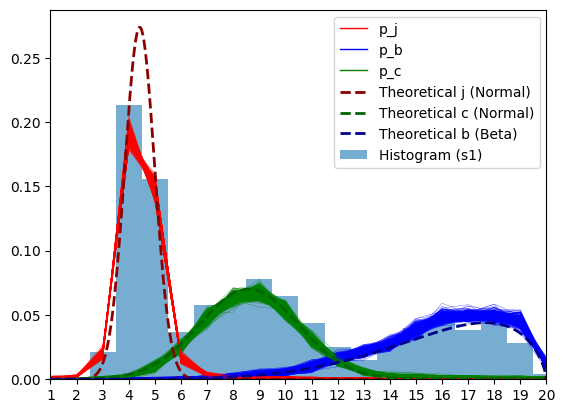

In [104]:
#Normalizing and plotting inferred distributions
for i in range(500):
    # Extract the p_j and p_b values for the current sample
    p_j_values = np.array([df_ordenado.iloc[i]['p_j.' + str(x)] for x in range(1, 21)])
    p_b_values = np.array([df_ordenado.iloc[i]['p_b.' + str(x)] for x in range(1, 21)])
    p_c_values = np.array([df_ordenado.iloc[i]['p_c.' + str(x)] for x in range(1, 21)])
    
    # Plot the normalized curves
    if i == 0:   #actualy, the normalization factor is not known ? the proportion of j,b,c indiv. components.
        plt.plot(range(1, 21), p_j_values*df['label_s1'].value_counts()['j']/N, lw = 1,color='red', label='p_j')
        plt.plot(range(1, 21), p_b_values*df['label_s1'].value_counts()['c']/N, lw = 1,color='blue', label='p_b')
        plt.plot(range(1, 21), p_c_values*df['label_s1'].value_counts()['c']/N, lw = 1,color='green', label='p_c')

    else:
        plt.plot(range(1, 21), p_j_values*df['label_s1'].value_counts()['j']/N, lw = 0.2,color='red')
        plt.plot(range(1, 21), p_b_values*df['label_s1'].value_counts()['c']/N, lw = 0.2,color='blue')
        plt.plot(range(1, 21), p_c_values*df['label_s1'].value_counts()['c']/N, lw = 0.2,color='green')


# Graficar las distribuciones teóricas reescaladas
plt.plot(x_rescaled, pdf_j_rescaled * df['label_s1'].value_counts()['j'] / N, label='Theoretical j (Normal)', ls='--', lw=2, color='darkred')
plt.plot(x_rescaled, pdf_c_rescaled * df['label_s1'].value_counts()['c'] / N, label='Theoretical c (Normal)', ls='--', lw=2, color='darkgreen')
plt.plot(x_rescaled, pdf_b_rescaled * df['label_s1'].value_counts()['b'] / N, label='Theoretical b (Beta)', ls='--', lw=2, color='darkblue')

plt.hist(df_rescaled['s1'], bins=bin_edges, density=True, alpha=0.6, label='Histogram (s1)')

plt.xticks(np.arange(1,m+1))
plt.xlim(1,m)
plt.legend()
#plt.grid(alpha=0.5)
plt.show()


In [64]:
list(df_4d)

['lp__',
 'accept_stat__',
 'stepsize__',
 'treedepth__',
 'n_leapfrog__',
 'divergent__',
 'energy__',
 'theta.1',
 'theta.2',
 'theta.3',
 'theta.4',
 'theta.5',
 'theta.6',
 'w_j_mode.1',
 'w_j_mode.2',
 'w_j_mode.3',
 'w_j_mode.4',
 'w_j_mode.5',
 'w_j_mode.6',
 'w_j_mode.7',
 'w_j_mode.8',
 'w_j_mode.9',
 'w_j_mode.10',
 'w_j_mode.11',
 'w_j_mode.12',
 'w_j_mode.13',
 'w_j_mode.14',
 'w_j_mode.15',
 'w_j_mode.16',
 'w_j_mode.17',
 'w_j_mode.18',
 'w_j_mode.19',
 'w_j_mode.20',
 'a_j.1',
 'a_j.2',
 'a_j.3',
 'a_j.4',
 'a_j.5',
 'a_j.6',
 'a_j.7',
 'a_j.8',
 'a_j.9',
 'a_j.10',
 'a_j.11',
 'a_j.12',
 'a_j.13',
 'a_j.14',
 'a_j.15',
 'a_j.16',
 'a_j.17',
 'a_j.18',
 'a_j.19',
 'w_b_mode.1',
 'w_b_mode.2',
 'w_b_mode.3',
 'w_b_mode.4',
 'w_b_mode.5',
 'w_b_mode.6',
 'w_b_mode.7',
 'w_b_mode.8',
 'w_b_mode.9',
 'w_b_mode.10',
 'w_b_mode.11',
 'w_b_mode.12',
 'w_b_mode.13',
 'w_b_mode.14',
 'w_b_mode.15',
 'w_b_mode.16',
 'w_b_mode.17',
 'w_b_mode.18',
 'w_b_mode.19',
 'w_b_mode.20',
 '

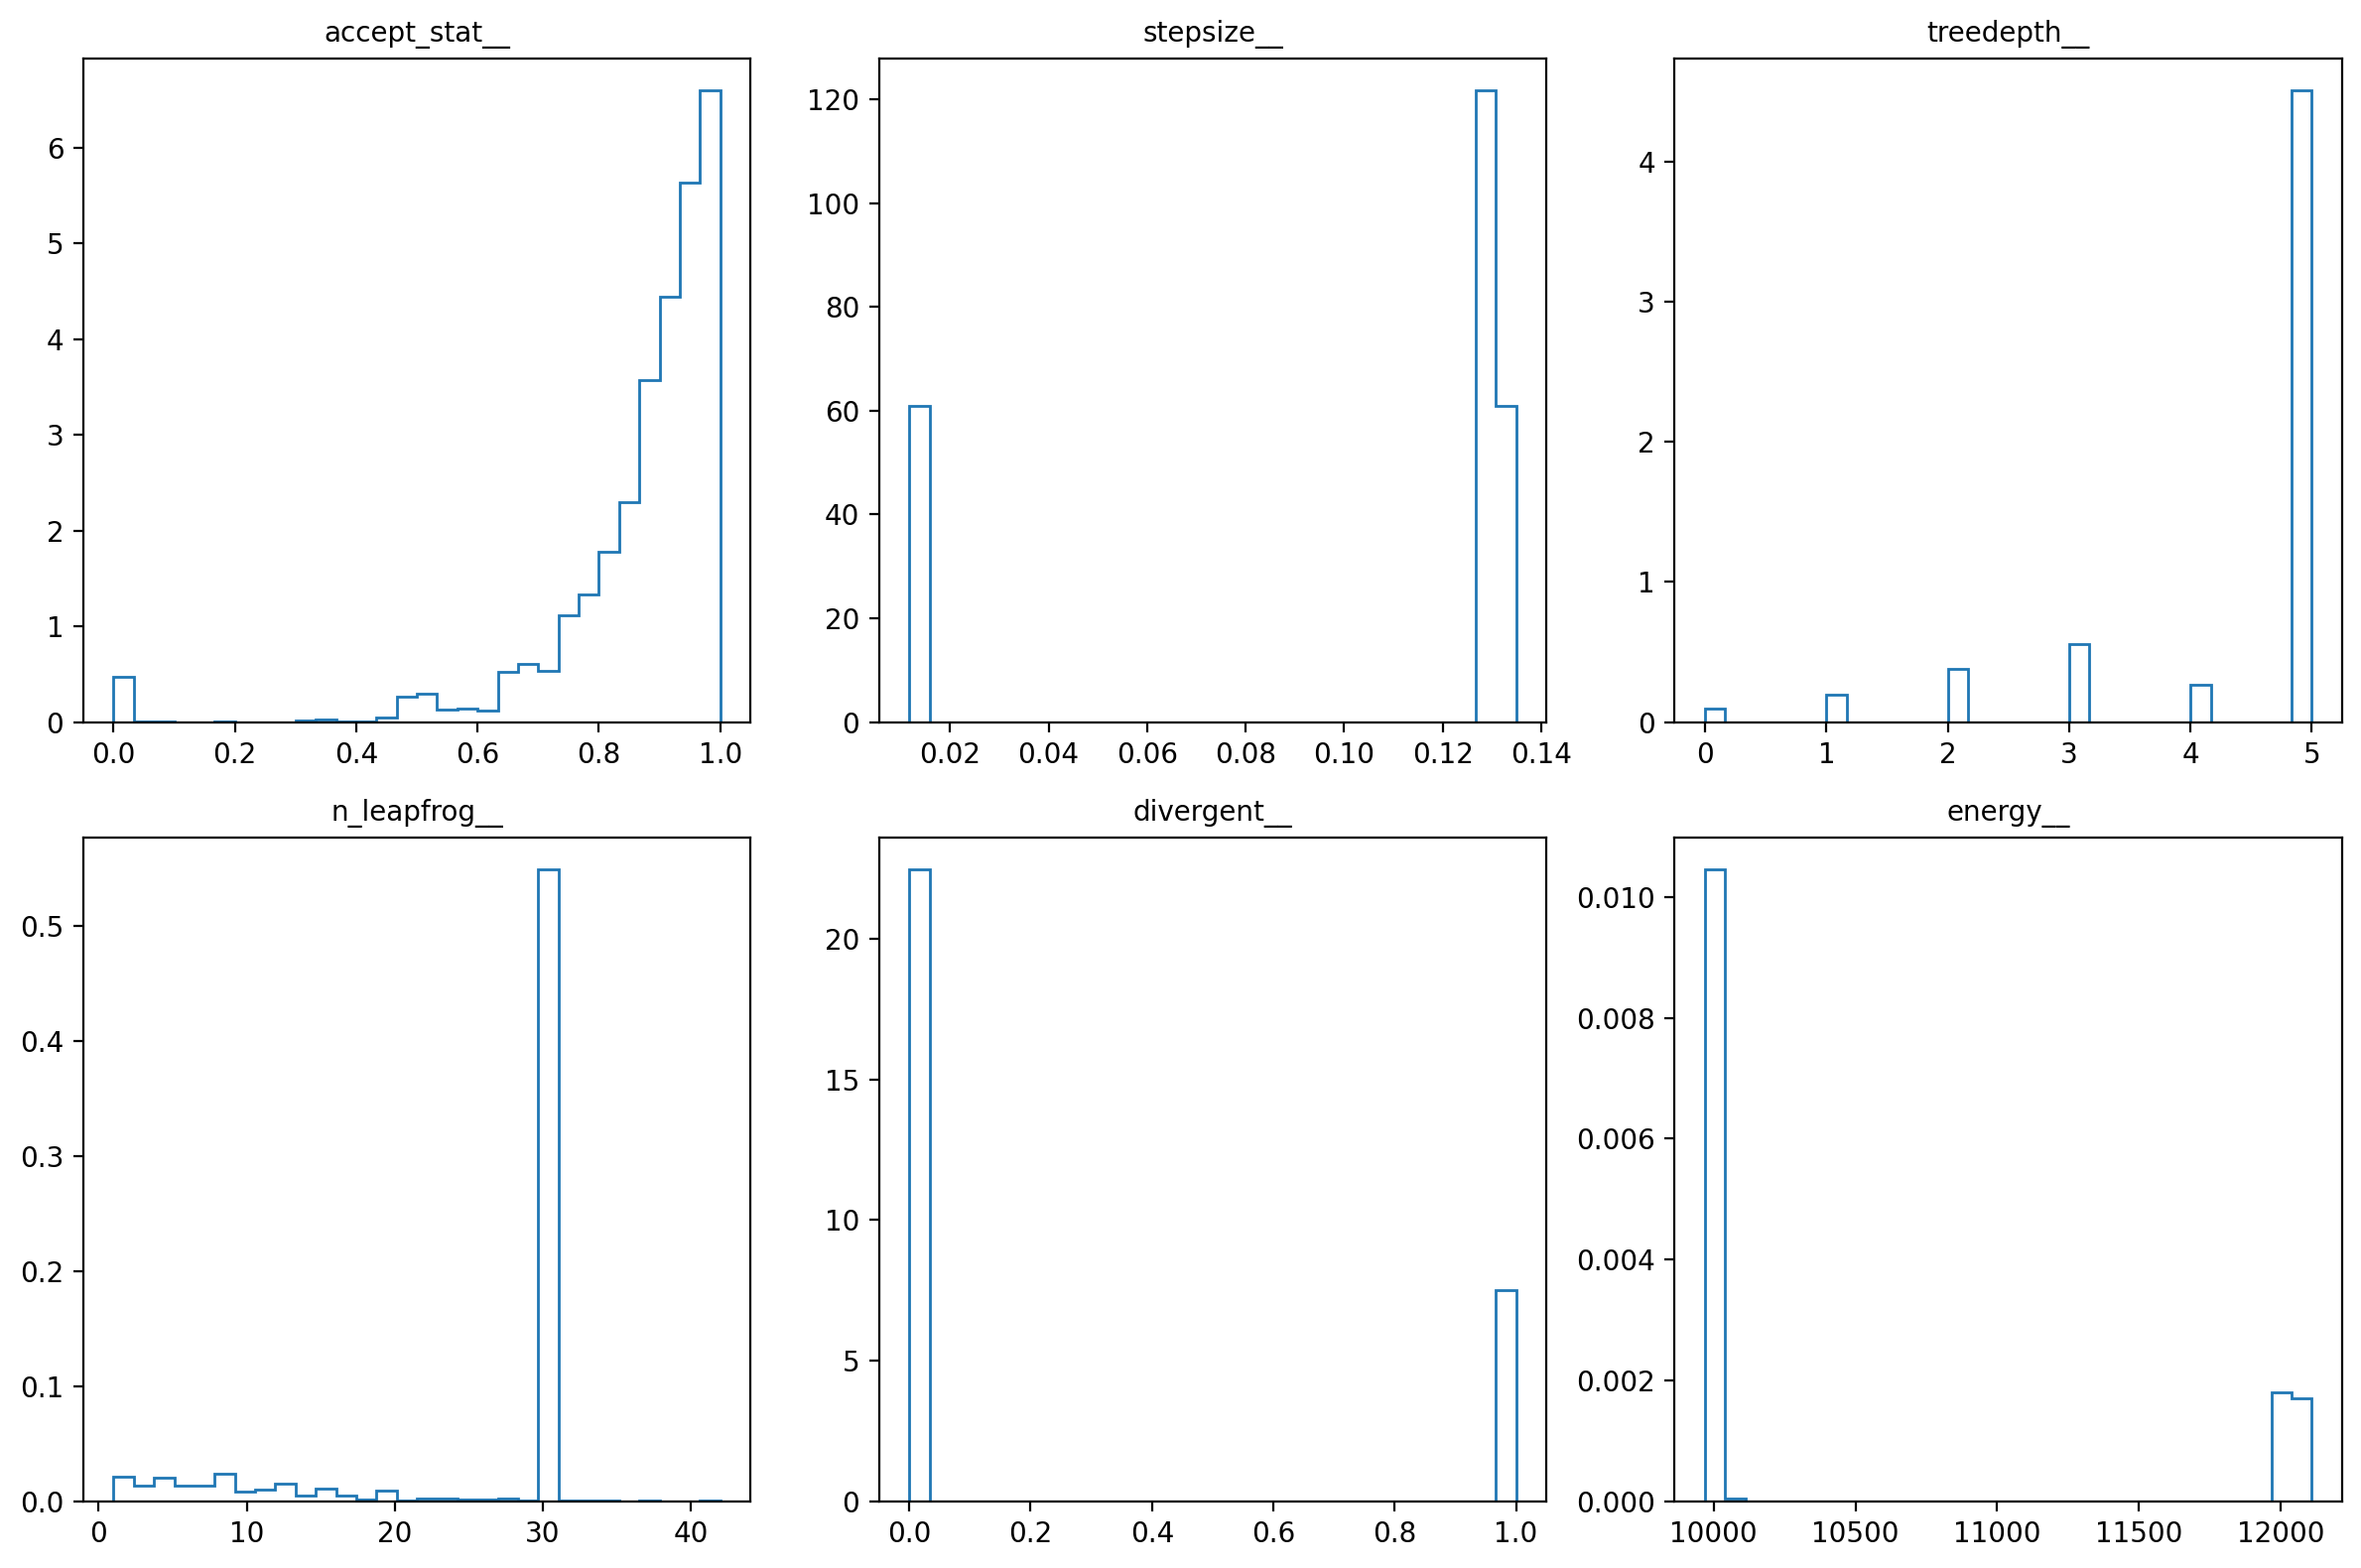

In [105]:
# Now define the posterior_4d with the relevant diagnostics columns
posterior_4d = df_4d[['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__']]

# Create subplots for each of the 6 diagnostic parameters
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=200)

# List of the diagnostic parameters
parameters = ['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__']

# Loop over the parameters and create histograms in subplots
for i, param in enumerate(parameters):
    row = i // 3  # Define the row for the subplot
    col = i % 3   # Define the column for the subplot
    axes[row, col].hist(posterior_4d[param], bins=30, histtype='step', density=True)
    axes[row, col].set_title(param, fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [106]:
posterior = az.from_pystan(fit_4d)

# Get the ArviZ summary
summary_df = az.summary(posterior)

summary_df

/home/tomas/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/tomas/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/tomas/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.194,0.047,0.114,0.240,0.023,0.017,7.0,17.0,1.54
theta[1],0.194,0.037,0.156,0.257,0.018,0.014,7.0,23.0,1.53
theta[2],0.164,0.110,0.085,0.355,0.055,0.042,7.0,13.0,1.58
theta[3],0.124,0.023,0.088,0.154,0.010,0.008,7.0,14.0,1.56
theta[4],0.178,0.017,0.157,0.207,0.006,0.004,8.0,33.0,1.42
...,...,...,...,...,...,...,...,...,...
logp_c[15],12.993,1.958,10.717,16.263,0.899,0.694,7.0,11.0,1.59
logp_c[16],13.467,1.906,11.170,16.617,0.865,0.668,7.0,11.0,1.59
logp_c[17],13.848,1.813,11.560,16.792,0.807,0.622,7.0,12.0,1.57
logp_c[18],14.819,2.700,11.946,19.421,1.278,0.987,7.0,11.0,1.59


In [107]:
summary_df['r_hat'].values

array([1.54, 1.53, 1.58, 1.56, 1.42, 1.57, 1.6 , 1.58, 1.42, 1.6 , 1.34,
       1.59, 1.59, 1.43, 1.12, 1.41, 1.1 , 1.6 , 1.57, 1.59, 1.59, 1.59,
       1.57, 1.59, 1.59, 1.55, 1.38, 1.56, 1.59, 1.53, 1.59, 1.53, 1.53,
       1.11, 1.12, 1.13, 1.19, 1.31, 1.55, 1.1 , 1.14, 1.57, 1.52, 1.53,
       1.57, 1.55, 1.56, 1.55, 1.53, 1.54, 1.56, 1.54, 1.43, 1.07, 1.53,
       1.52, 1.52, 1.27, 1.08, 1.28, 1.09, 1.13, 1.36, 1.08, 1.17, 1.36,
       1.59, 1.57, 1.54, 1.59, 1.09, 1.53, 1.16, 1.53, 1.56, 1.59, 1.51,
       1.18, 1.26, 1.59, 1.53, 1.56, 1.58, 1.3 , 1.59, 1.57, 1.53, 1.53,
       1.54, 1.56, 1.22, 1.07, 1.56, 1.25, 1.13, 1.53, 1.57, 1.59, 1.2 ,
       1.29, 1.17, 1.49, 1.58, 1.59, 1.15, 1.21, 1.23, 1.59, 1.56, 1.57,
       1.6 , 1.53, 1.54, 1.46, 1.51, 1.54, 1.46, 1.14, 1.53, 1.56, 1.07,
       1.59, 1.56, 1.59, 1.59, 1.54, 1.59, 1.55, 1.54, 1.59, 1.54, 1.5 ,
       1.59, 1.59, 1.59, 1.59, 1.59, 1.59, 1.6 , 1.59, 1.59, 1.59, 1.59,
       1.59, 1.59, 1.59, 1.59, 1.6 , 1.59, 1.59, 1.

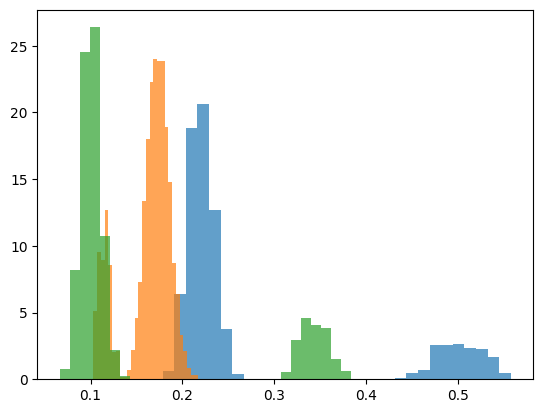

In [85]:
plt.hist(df_4d['theta.1'],bins=30,alpha=0.7,density=True)
plt.hist(df_4d['theta.2'],bins=30,alpha=0.7,density=True)
plt.hist(df_4d['theta.3'],bins=30,alpha=0.7,density=True)
#plt.hist(df_4d['theta.4'],bins=30)
#plt.hist(df_4d['theta.5'],bins=30)
#plt.hist(df_4d['theta.6'],bins=30)
plt.show()